# The ChiSquare "Miracle"

This is an illustration of how the ChiSquare minimum (and hence Minuit) obtains uncertainties on the estimates (in fact a full covariance matrix between fitting parameters).

Converted to (scrollable) html-slides as follows:<br>
  jupyter nbconvert --to slides --SlidesExporter.reveal_scroll=True TheChiSquareMiracle_original.ipynb

***

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 10th of November 2025 (latest update)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from iminuit import Minuit
from iminuit.cost import LeastSquares

## Generating and plotting data:

In [2]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

Npoints = 10000     # Number of random points produced
x_all = r.normal(loc=-0.7, scale=1.1, size=Npoints)

Nbins = 100
xmin, xmax = -5, 5
binwidth = (xmax-xmin)/Nbins

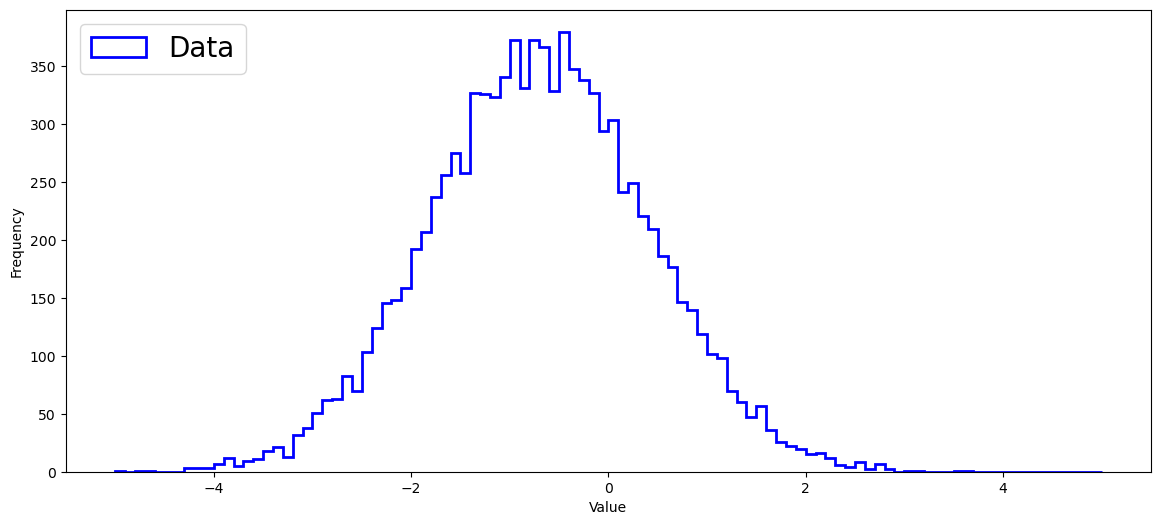

In [3]:
fig, ax = plt.subplots(figsize=(14, 6))
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='blue', label='Data')
ax.set(xlabel="Value", ylabel="Frequency", title="")
ax.legend(loc='upper left', fontsize=20);

## Fitting data:

In [4]:
# Minuit.print_level = 1      # Printing result of the fit

# Define Gaussian PDF:
def func_gauss(x, N, mu, sigma):
    z = (x - mu) / sigma
    return N * binwidth / np.sqrt(2 * np.pi) / sigma * np.exp(-0.5 * z**2)

# Turning histogram data into x, y, and sigma_y values
# for all non-zero entries (not considered in Chi2 fit):
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax), density=False)
x = 0.5*(bin_edges[:-1] + bin_edges[1:])[counts>0]
y = counts[counts>0]
sy = np.sqrt(y)            # We'll talk more about this choice in the course!

In [5]:
least_squares = LeastSquares(x, y, sy, func_gauss)         # Defines the ChiSquare fit
mfit = Minuit(least_squares, N=1000, mu=0.0, sigma=1.0)    # Defines the Minuit object "mfit" and starting values
mfit.migrad()                                              # Finds minimum of least_squares function (i.e. fits!)
mfit.hesse()                                               # Accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.77 (χ²/ndof = 0.8)      │              Nfcn = 87               │
│ EDM = 5.85e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  9.94e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ mu    │  -0.700   │   0.011   │            │            │         │         │       │
│ 2 │ sigma │   1.096   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        N       mu    sigma │
├───────┼────────────────────────────┤
│     N │ 9.95e+03 -0.41e-3  4.58e-3 │
│    mu │ -0.41e-3 0.000122        0 │
│ sigma │  4.58e-3        0  6.4e-05 │
└───────┴────────────────────────────┘

In [6]:
# Print fit result (Notice: Incorrect number of decimals!):
for name in mfit.parameters :
    value, error = mfit.values[name], mfit.errors[name]
    print(f"Fit value: {name} = {value:.4f} +/- {error:.4f}")

Chi2 = mfit.fval           # The minimisation (here Chi2) value
Ndof = len(x) - len(mfit.values[:])
Prob = stats.chi2.sf(Chi2, Ndof)
print(f"\nProb(Chi2 = {Chi2:.1f}, Ndof = {Ndof:d}) = {Prob:6.4f}")

Fit value: N = 9943.0439 +/- 99.7507
Fit value: mu = -0.7000 +/- 0.0110
Fit value: sigma = 1.0957 +/- 0.0080

Prob(Chi2 = 62.8, Ndof = 76) = 0.8616


In [7]:
# Produce the points for drawing the fit:
x_fit = np.linspace(xmin, xmax, 500)
y_fit = func_gauss(x_fit, mfit.values[0], mfit.values[1], mfit.values[2])

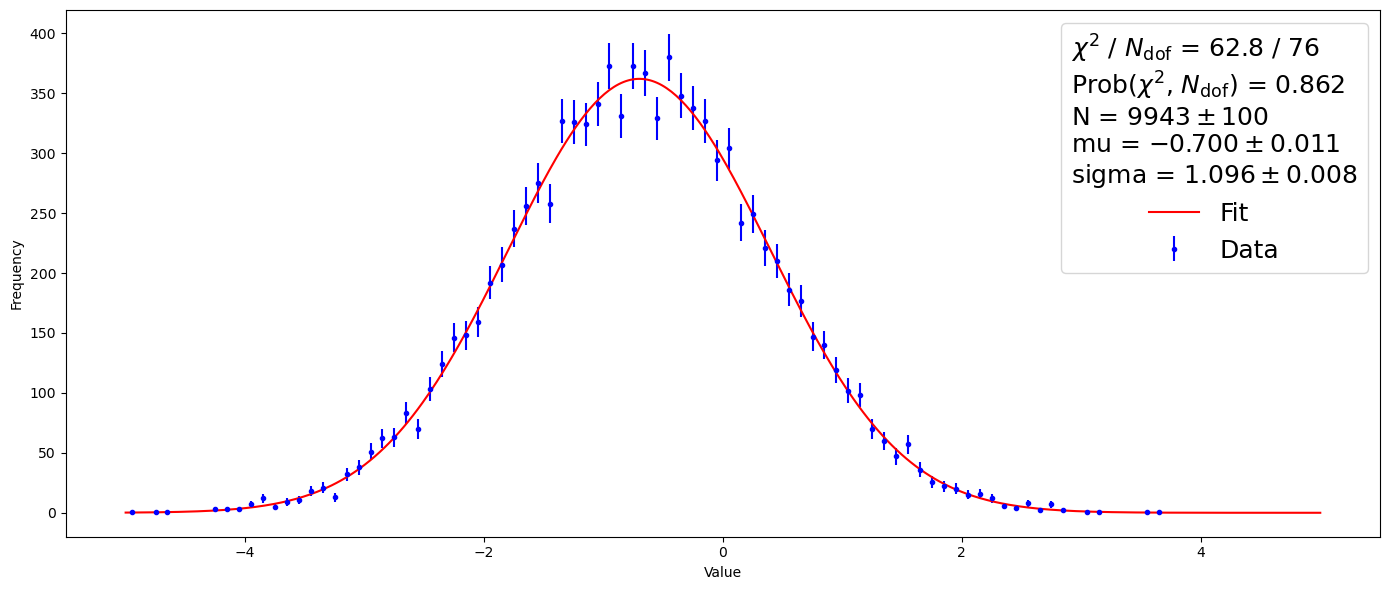

In [8]:
# Produce figure with histogram (with error bars) and fit overlayed:
fig2, ax2 = plt.subplots(figsize=(14, 6))
ax2.errorbar(x, y, sy, fmt='.', color='blue', label='Data')
ax2.plot(x_fit, y_fit, '-', color='red', label='Fit')
ax2.set(xlabel="Value", ylabel="Frequency", title="")
ax2.legend(loc='upper left', fontsize=24)

# Produce a nice writeup of the fitting result in the figure:
fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {Chi2:.1f} / {Ndof}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
for p, v, e in zip(mfit.parameters, mfit.values[:], mfit.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")
plt.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center')

fig2.tight_layout()

## How does Minuit determine the uncertainties?

In [9]:
# Comparing fit result to the non-fit estimate of the mean and its uncertainty:
mu = np.mean(x_all)
error_mu = np.std(x_all) / np.sqrt(len(x_all))
print(f"The mean of x_all was = {mu:.3f} +- {error_mu:.3f}")
print(f"Sigma(mean) from the CALCULATION is:   {error_mu:.5f}")

The mean of x_all was = -0.702 +- 0.011
Sigma(mean) from the CALCULATION is:   0.01104


In [10]:
print(f"Sigma(mean) from the CHISQUARE FIT is: {mfit.errors[1]:.5f}")

Sigma(mean) from the CHISQUARE FIT is: 0.01104


In [11]:
print(f"HOW THE H*** DID MINUIT/CHISQUARE 'KNOW' THIS?!?")

HOW THE H*** DID MINUIT/CHISQUARE 'KNOW' THIS?!?


In [12]:
# Exploring the value of the Chi2 as a function of the value of the mean:

# Defining own Chi2 calculation:
def chi2_owncalc(N, mu, sigma) :
    y_fit = func_gauss(x, N, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Calculating the points along the ChiSquare curve:
x_chi2 = np.linspace(mu-2*error_mu, mu+2*error_mu, 200)
y_chi2 = np.zeros(len(x_chi2))
for i in range(len(y_chi2)) :
    y_chi2[i] = chi2_owncalc(mfit.values[0], x_chi2[i], mfit.values[2])

chi2min = np.min(y_chi2)
print(f"  The minimal Chi2 value is: {chi2min:5.2f}")

  The minimal Chi2 value is: 62.77


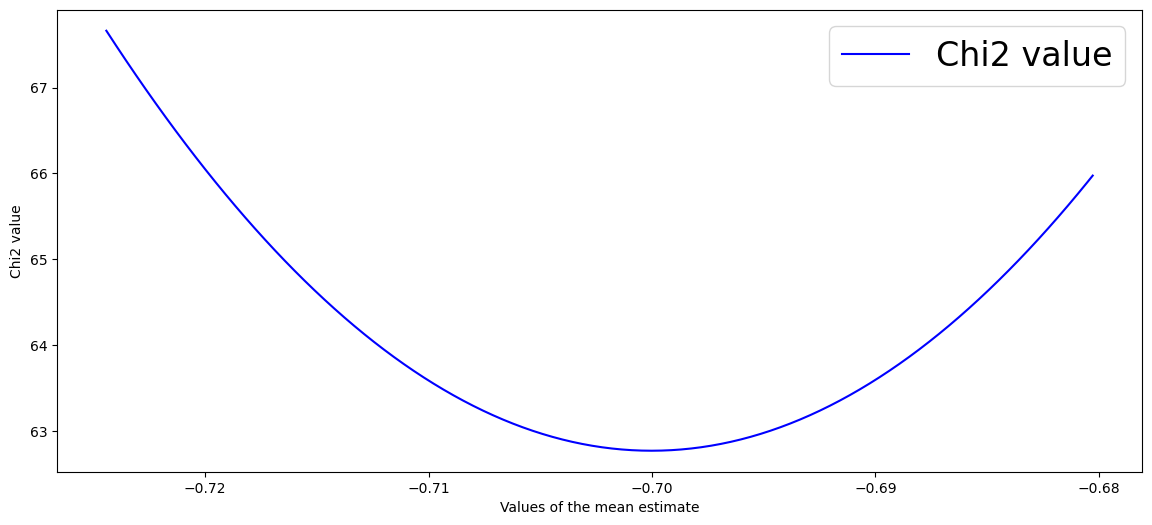

In [13]:
fig3, ax3 = plt.subplots(figsize=(14, 6))
ax3.plot(x_chi2, y_chi2, '-', color='blue', label='Chi2 value')
ax3.set(xlabel="Values of the mean estimate", ylabel="Chi2 value", title="")
ax3.legend(loc='upper right', fontsize=24);

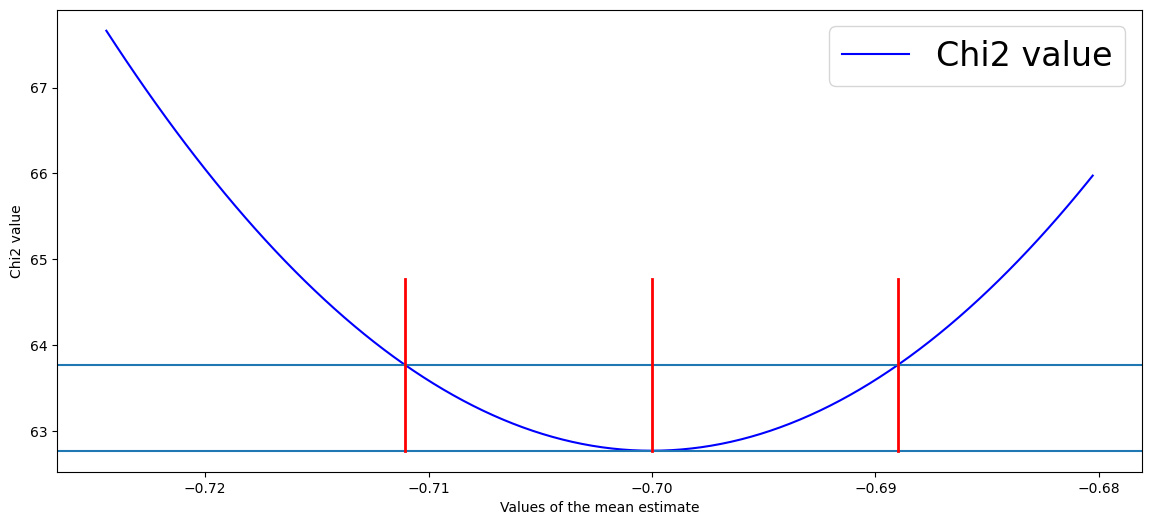

In [14]:
fig3, ax3 = plt.subplots(figsize=(14, 6))
ax3.plot(x_chi2, y_chi2, '-', color='blue', label='Chi2 value')
ax3.set(xlabel="Values of the mean estimate", ylabel="Chi2 value", title="")
ax3.legend(loc='upper right', fontsize=24)

# Draw horizontal lines at minimum Chi2 and minimum Chi2+1:
plt.axhline(y=chi2min); plt.axhline(y=chi2min+1)

# Draw vertical lines where the Chi2 reaches the minimum Chi2+1:
x_chi2min = mfit.values[1]
dx        = mfit.errors[1]    # X-value at Chi2+1
plt.plot([x_chi2min-dx, x_chi2min-dx], [chi2min, chi2min+2], 'r', linewidth=2)
plt.plot([x_chi2min,    x_chi2min],    [chi2min, chi2min+2], 'r', linewidth=2)
plt.plot([x_chi2min+dx, x_chi2min+dx], [chi2min, chi2min+2], 'r', linewidth=2)
plt.show()

In [15]:
! jupyter nbconvert --to slides --SlidesExporter.reveal_scroll=True TheChiSquareMiracle_original.ipynb

/opt/anaconda3/envs/appstat24/bin/jupyter-nbconvert:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  from nbconvert.nbconvertapp import main
[NbConvertApp] Converting notebook TheChiSquareMiracle_original.ipynb to slides
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 544248 bytes to TheChiSquareMiracle_original.slides.html
